In [1]:
# 기본 라이브러리 임포트
import pandas as pd             
import numpy as np             
import matplotlib.pyplot as plt 
import seaborn as sns           
import gc                       # 가비지 컬렉션(메모리 해제)
import re                       # 정규 표현식 처리
from collections import defaultdict  # 기본값이 있는 딕셔너리 생성

# 경고 메시지 억제
import warnings
warnings.filterwarnings('ignore')   

# 그래프 스타일 설정
sns.set()                           # seaborn 기본 스타일 적용

# matplotlib 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
# plt.rcParams['font.family'] = 'AppleGothic'  
plt.rcParams['figure.figsize'] = (12, 6)       # 그림 크기 설정 (가로, 세로)
plt.rcParams['font.size'] = 14                 # 폰트 크기 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 결측치 시각화 라이브러리 임포트
import missingno                          # 결측치 분포를 시각화하는 유틸리티

# 범주형 변수 레이블 인코딩을 위한 도구 임포트
from sklearn.preprocessing import LabelEncoder

# 중복 조합 생성에 사용할 product 함수 임포트
from itertools import product

# 회귀 및 통계 분석을 위한 statsmodels 임포트
import statsmodels.api as sm

# 다중공선성 진단용 VIF 계산 함수 임포트
from statsmodels.stats.outliers_influence import variance_inflation_factor

### 데이터 병합

In [2]:
# 채널정보 파일 읽기
channel_df = pd.read_parquet('open/concat/2018_마케팅정보.parquet')

# 회원정보 파일 읽기
member_df  = pd.read_parquet('open/concat/2018_회원정보.parquet')

# 회원정보에서 ID와 Segment 컬럼만 추출
member_seg = member_df[['ID', 'Segment']]

# 중복된 ID 개수 확인
dup_count = member_seg['ID'].duplicated().sum()
print(f'중복된 ID 개수: {dup_count}')

# 중복된 ID를 첫 번째 항목만 남기고 제거
member_seg_unique = member_seg.drop_duplicates(subset='ID', keep='first')
print(f'중복 제거 후 행 수: {len(member_seg_unique)}')

# 채널정보에 Segment 컬럼 병합 (1:1 조인 보장)
df = channel_df.merge(member_seg_unique, on='ID', how='left')

# 결과 확인
print("병합 후 데이터프레임 크기:", df.shape)
print(df.head())

# 병합된 파일 저장
df.to_parquet('2018_마케팅정보_with_segment.parquet', index=False)

중복된 ID 개수: 2500000
중복 제거 후 행 수: 500000
병합 후 데이터프레임 크기: (3000000, 65)
     기준년월            ID  컨택건수_카드론_TM_B0M  컨택건수_리볼빙_TM_B0M  컨택건수_CA_TM_B0M  \
0  201807  TRAIN_000000                0                0               0   
1  201807  TRAIN_000001                3                0               0   
2  201807  TRAIN_000002                0                0               0   
3  201807  TRAIN_000003                0                0               0   
4  201807  TRAIN_000004                0                0               0   

   컨택건수_이용유도_TM_B0M  컨택건수_신용발급_TM_B0M  컨택건수_부대서비스_TM_B0M  컨택건수_포인트소진_TM_B0M  \
0                 0                 0                  0                  0   
1                 0                 0                  0                  0   
2                 0                 0                  0                  0   
3                 0                 0                  0                  0   
4                 0                 0                  0                 

In [3]:
# 데이터를 불러온다.
df = pd.read_parquet('2018_마케팅정보_with_segment.parquet')
df

,기준년월,ID,컨택건수_카드론_TM_B0M,컨택건수_리볼빙_TM_B0M,컨택건수_CA_TM_B0M,컨택건수_이용유도_TM_B0M,컨택건수_신용발급_TM_B0M,컨택건수_부대서비스_TM_B0M,컨택건수_포인트소진_TM_B0M,컨택건수_보험_TM_B0M,...,컨택건수_CA_당사앱_R6M,컨택건수_리볼빙_당사앱_R6M,컨택건수_이용유도_당사앱_R6M,컨택건수_채권_B0M,컨택건수_FDS_B0M,컨택건수_채권_R6M,컨택건수_FDS_R6M,캠페인접촉건수_R12M,캠페인접촉일수_R12M,Segment
0,201807,TRAIN_000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1회 이상,1일 이상,D
1,201807,TRAIN_000001,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,15회 이상,10일 이상,E
2,201807,TRAIN_000002,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1회 이상,1일 이상,C
3,201807,TRAIN_000003,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1회 이상,1일 이상,D
4,201807,TRAIN_000004,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1회 이상,1일 이상,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,201812,TEST_99995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1회 이상,1일 이상,None
2999996,201812,TEST_99996,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1회 이상,1일 이상,None
2999997,201812,TEST_99997,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,1회 이상,1일 이상,None
2999998,201812,TEST_99998,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5회 이상,5일 이상,None


### 결측치 찾기
- 결측치를 가진 행이 없어서 넘어가도록 하겠음

In [4]:
# 전체 행 개수 계산
total_rows = len(df)

# 각 컬럼의 결측치 개수 계산
missing_count = df.isna().sum()

# 결측치 비율 계산 (전체 행 대비 %)
missing_pct = (missing_count / total_rows * 100).round(2)

# 결측치 정보 데이터프레임으로 정리
missing_info = pd.DataFrame({
    'missing_count': missing_count,
    'missing_pct': missing_pct
})

# 결측치가 있는 컬럼만 출력
print("\n결측치 정보 (개수 및 전체 대비 비율 %):")
print(missing_info[missing_info['missing_count'] > 0])


결측치 정보 (개수 및 전체 대비 비율 %):
         missing_count  missing_pct
Segment         600000         20.0


### 값이 모두 0인 컬러도 제외

In [5]:
# 전부 0인 컬럼 찾기
zero_cols = [c for c in df.columns if df[c].eq(0).all()]

print("모두 0인 컬럼 (제거 대상):")
print(zero_cols)

# 전부 0인 컬럼 제거
df.drop(columns=zero_cols, inplace = True)

# 4) 결과 확인
print("최종 DataFrame shape:", df.shape)
print("남은 컬럼:", df.columns.tolist())

모두 0인 컬럼 (제거 대상):
['컨택건수_CA_TM_B0M', '컨택건수_포인트소진_TM_B0M', '컨택건수_CA_EM_B0M', '컨택건수_리볼빙_EM_B0M', '컨택건수_리볼빙_청구서_B0M', '컨택건수_카드론_인터넷_B0M', '컨택건수_CA_인터넷_B0M', '컨택건수_리볼빙_인터넷_B0M', '컨택건수_카드론_당사앱_B0M', '컨택건수_CA_당사앱_B0M', '컨택건수_리볼빙_당사앱_B0M', '컨택건수_CA_EM_R6M', '컨택건수_리볼빙_EM_R6M', '컨택건수_리볼빙_청구서_R6M', '컨택건수_카드론_인터넷_R6M', '컨택건수_CA_인터넷_R6M', '컨택건수_리볼빙_인터넷_R6M', '컨택건수_카드론_당사앱_R6M', '컨택건수_CA_당사앱_R6M', '컨택건수_리볼빙_당사앱_R6M', '컨택건수_FDS_B0M', '컨택건수_FDS_R6M']
최종 DataFrame shape: (3000000, 43)
남은 컬럼: ['기준년월', 'ID', '컨택건수_카드론_TM_B0M', '컨택건수_리볼빙_TM_B0M', '컨택건수_이용유도_TM_B0M', '컨택건수_신용발급_TM_B0M', '컨택건수_부대서비스_TM_B0M', '컨택건수_보험_TM_B0M', '컨택건수_카드론_LMS_B0M', '컨택건수_CA_LMS_B0M', '컨택건수_리볼빙_LMS_B0M', '컨택건수_이용유도_LMS_B0M', '컨택건수_카드론_EM_B0M', '컨택건수_이용유도_EM_B0M', '컨택건수_카드론_청구서_B0M', '컨택건수_CA_청구서_B0M', '컨택건수_이용유도_청구서_B0M', '컨택건수_이용유도_인터넷_B0M', '컨택건수_이용유도_당사앱_B0M', '컨택건수_카드론_TM_R6M', '컨택건수_CA_TM_R6M', '컨택건수_리볼빙_TM_R6M', '컨택건수_이용유도_TM_R6M', '컨택건수_신용발급_TM_R6M', '컨택건수_부대서비스_TM_R6M', '컨택건수_포인트소진_TM_R6M', '컨택건수_보험_TM_R6M', '컨택건수_카드론_

### 비수치형 또는 혼합형 컬럼 찾아 숫자로 변환하기

In [6]:
# 각 컬럼별 분포(value_counts) 출력
c1 = list (df.columns)
for col in c1:
    print(f"▶ [{col}] 분포")
    print(df[col].value_counts(dropna=False))
    print()  # 빈 줄로 구분

▶ [기준년월] 분포
기준년월
201807    500000
201808    500000
201809    500000
201810    500000
201811    500000
201812    500000
Name: count, dtype: int64

▶ [ID] 분포
ID
TRAIN_000000    6
TRAIN_333343    6
TRAIN_333341    6
TRAIN_333340    6
TRAIN_333339    6
               ..
TRAIN_166662    6
TRAIN_166661    6
TRAIN_166660    6
TRAIN_166659    6
TEST_99999      6
Name: count, Length: 500000, dtype: int64

▶ [컨택건수_카드론_TM_B0M] 분포
컨택건수_카드론_TM_B0M
0    2837983
3     149170
4      12820
2         27
Name: count, dtype: int64

▶ [컨택건수_리볼빙_TM_B0M] 분포
컨택건수_리볼빙_TM_B0M
0    2999985
1         10
2          5
Name: count, dtype: int64

▶ [컨택건수_이용유도_TM_B0M] 분포
컨택건수_이용유도_TM_B0M
0    2918556
3      75407
2       6037
Name: count, dtype: int64

▶ [컨택건수_신용발급_TM_B0M] 분포
컨택건수_신용발급_TM_B0M
0    2999992
1          8
Name: count, dtype: int64

▶ [컨택건수_부대서비스_TM_B0M] 분포
컨택건수_부대서비스_TM_B0M
0    2999999
1          1
Name: count, dtype: int64

▶ [컨택건수_보험_TM_B0M] 분포
컨택건수_보험_TM_B0M
0    2960541
1      39459
Name: count, dtyp

In [7]:
# 검사할 컬럼 리스트
c1 = list (df.columns)
cols_to_check = c1

# 비수치형 컬럼 저장용 리스트
non_numeric_cols = []

# 각 컬럼에 대해 수치형 변환 시도 후 NaN 비율로 판단
for col in cols_to_check:
    # 결측을 빈 문자열로, 나머지를 문자열로 변환
    s = df[col].fillna('').astype(str)
    # 숫자로 변환 (불가능한 항목은 NaN)
    num = pd.to_numeric(s, errors='coerce')
    # 변환 불가 비율 계산
    na_ratio = num.isna().mean()
    # 일정 비율 이상이면 비수치형으로 간주 (여기선 100% 미수치형도 포함)
    if na_ratio > 0:
        non_numeric_cols.append(col)

# 결과 출력
print("비수치형(또는 혼합형) 컬럼:", non_numeric_cols)

비수치형(또는 혼합형) 컬럼: ['ID', '캠페인접촉건수_R12M', '캠페인접촉일수_R12M', 'Segment']


In [8]:
# 숫자와 문자가 섞여 있는 컬럼 리스트 정의
cols = [
    '캠페인접촉일수_R12M',
    '캠페인접촉건수_R12M'
]

# 숫자 추출해서 새로운 수치형 컬럼 생성
for col in cols:
    # 문자열로 변환하고 숫자만 추출
    s = df[col].fillna('').astype(str)
    df[f'{col}_num'] = s.str.extract(r'(\d+)', expand=False)
    # 숫자로 변환, 변환 실패는 0으로 대체
    df[f'{col}_num'] = pd.to_numeric(df[f'{col}_num'], errors='coerce').fillna(0).astype(int)

# 원본 컬럼 삭제 
df.drop(columns=cols, inplace=True)

In [9]:
# drop 이후, 저장 직전의 컬럼과 0/NaN 컬럼 재확인
zero_cols = [c for c in df.columns if df[c].eq(0).all()]
na_cols   = [c for c in df.columns if df[c].isna().any()]

print("저장 직전 0 전부 컬럼:", zero_cols)
print("저장 직전 NaN 있는 컬럼:", na_cols)
print("저장 직전 전체 컬럼 수:", len(df.columns))

저장 직전 0 전부 컬럼: []
저장 직전 NaN 있는 컬럼: ['Segment']
저장 직전 전체 컬럼 수: 43


In [10]:
# Parquet 파일로 저장
df.to_parquet('마케팅정보_결측치_제거.parquet', engine='pyarrow', index=False)

In [11]:
# 저장된 파일 불러와서 확인하기
df2 = pd.read_parquet('마케팅정보_결측치_제거.parquet')
zero_after = [c for c in df2.columns if df2[c].eq(0).all()]
na_after   = [c for c in df2.columns if df2[c].isna().any()]

print("로드 후 0 전부 컬럼:", zero_after)
print("로드 후 NaN 있는 컬럼:", na_after)
print("로드 후 전체 컬럼 수:", len(df2.columns))

로드 후 0 전부 컬럼: []
로드 후 NaN 있는 컬럼: ['Segment']
로드 후 전체 컬럼 수: 43


### 이상치 처리 생략
- 대부분의 값이 0에 밀집되어 있어 개별 이상치 제거가 오히려 주요 분포 파악을 방해하므로, 별도의 이상치 필터링 없이 바로 EDA를 진행할 예정

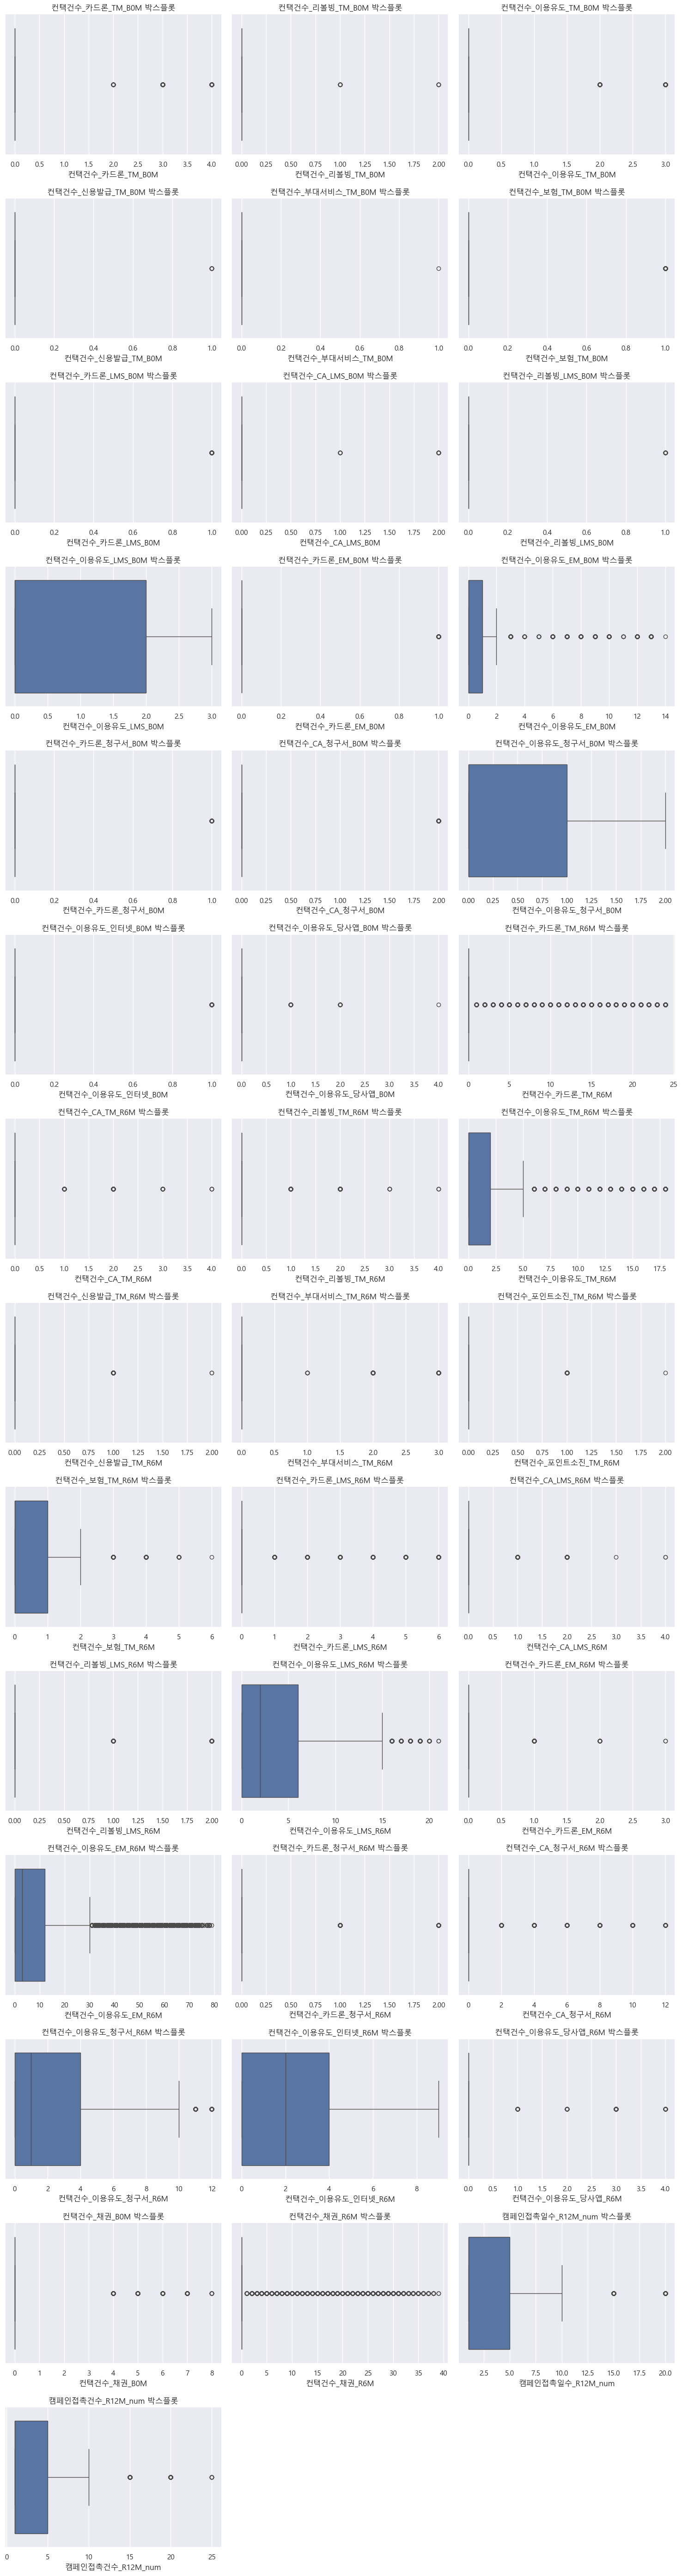

In [12]:
# 수치형 컬럼 중 ID 컬럼 제외
num_cols = df2.drop(columns=['ID', '기준년월']).select_dtypes(include='number').columns.tolist()

# 생성: 박스플롯을 위한 서브플롯 그리드 설정
n = len(num_cols)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

# 그리기: 각 수치형 컬럼에 대한 박스플롯(이상치·극단치 시각화)
for ax, col in zip(axes, num_cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"{col} 박스플롯")
# 빈 서브플롯 숨기기
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()